In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np

import caustic

In [2]:
# initialization stuff for lenses
cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)

In [3]:
N_planes = 10
N_lenses = 2 # per plane

z_plane = np.linspace(0.1, 1.0, N_planes)
planes = []

for p, z_p in enumerate(z_plane):
    lenses = []
    
    for _ in range(N_lenses):
        lenses.append(
            caustic.PseudoJaffe(
                cosmology = cosmology, 
                z_l = z_p,
                x0 = torch.tensor(np.random.uniform(-fov/3., fov/3.)),
                y0 = torch.tensor(np.random.uniform(-fov/3., fov/3.)),
                convergence_0 = torch.tensor(10),
                core_radius = 0.01,
                scale_radius = torch.tensor(10**np.random.uniform(-0.5,0.5)),
                s = torch.tensor(0.001),
            )
        )

    planes.append(
        caustic.lenses.SinglePlane(z_l = z_p, cosmology = cosmology, lenses = lenses, name = f"plane {p}")
    )
    
lens = caustic.lenses.Multiplane(name = "multiplane", cosmology = cosmology, lenses = planes)

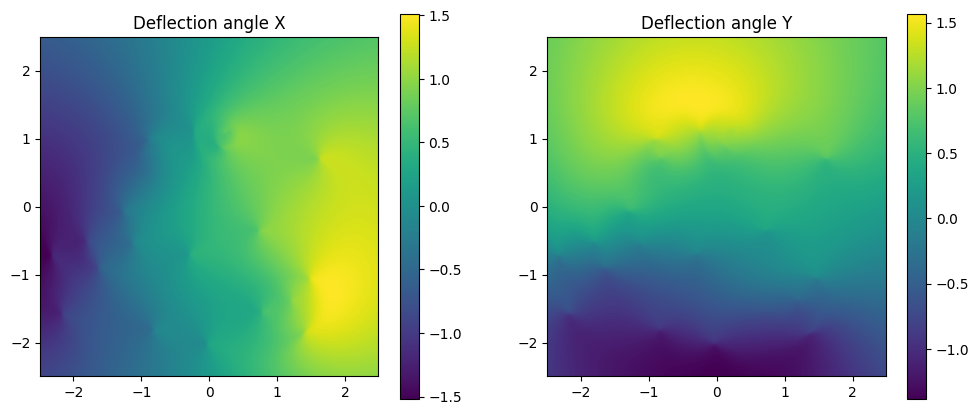

In [4]:
# Effective reduced deflection angles for the multiplane lens system
ax, ay = lens.effective_reduced_deflection_angle(thx, thy, z_s)

# Plot
fig, axarr = plt.subplots(1,2,figsize = (12,5))
im = axarr[0].imshow(ax, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[0].set_title("Deflection angle X")
plt.colorbar(im)
im = axarr[1].imshow(ay, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[1].set_title("Deflection angle Y")
plt.colorbar(im)
plt.show()

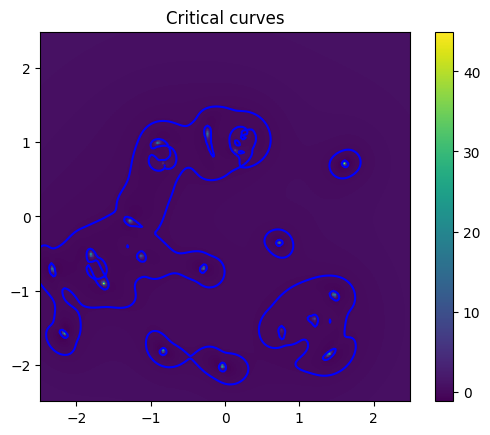

In [5]:
# Compute critical curves using effective difflection angle
J = lens.jacobian_effective_reduced_deflection_angle(thx, thy, z_s)

# Here we compute A and it's determinant at every point
A = torch.eye(2) - J
detA = torch.linalg.det(A)

# Plot the critical line
im = plt.imshow(detA, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
plt.colorbar(im)
CS = plt.contour(thx, thy, detA, levels = [0.], colors = "b")
plt.title("Critical curves")
plt.show()

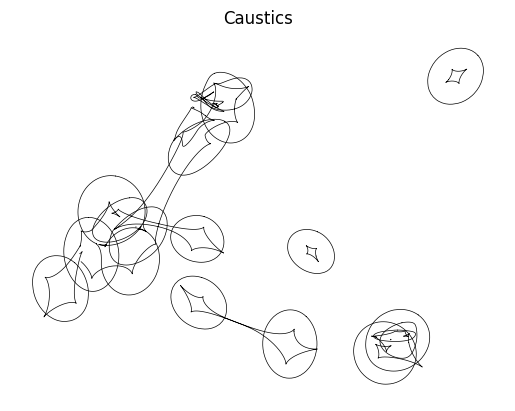

In [6]:
# For completeness, here are the caustics!
paths = CS.collections[0].get_paths()
caustic_paths = []
for path in paths:
    # Collect the path into a descrete set of points
    vertices = path.interpolated(5).vertices
    x1 = torch.tensor(list(float(vs[0]) for vs in vertices))
    x2 = torch.tensor(list(float(vs[1]) for vs in vertices))
    # raytrace the points to the source plane
    y1,y2 = lens.raytrace(x1, x2, z_s)

    # Plot the caustic
    plt.plot(y1,y2, color = "k", linewidth = 0.5)
plt.gca().axis("off")
plt.title("Caustics")
plt.show()